# Available Datasets

In [1]:
0

0

In [2]:
import copy
import gc
import logging
import os
import sys
import warnings

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scanpy.preprocessing._highly_variable_genes import highly_variable_genes
import tqdm
import scipy
from functools import reduce

sc.settings.verbosity = 3

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [4]:
def deep_memory_usage(obj, seen=None):
    """Recursively estimate memory usage of objects, including sparse arrays."""
    if seen is None:
        seen = set()
    # Avoid duplicate references
    if id(obj) in seen:
        return 0
    seen.add(id(obj))
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum([deep_memory_usage(v, seen) for v in obj.values()])
        size += sum([deep_memory_usage(k, seen) for k in obj.keys()])
    elif isinstance(obj, (list, tuple, set, frozenset)):
        size += sum([deep_memory_usage(i, seen) for i in obj])
    elif isinstance(obj, (pd.DataFrame, pd.Series)):
        size += obj.memory_usage(deep=True).sum()
    elif isinstance(obj, np.ndarray):
        size += obj.nbytes
    elif scipy.sparse.issparse(obj):
        # For sparse matrices, consider the data, indices, and indptr arrays
        size += obj.data.nbytes + obj.indices.nbytes + obj.indptr.nbytes
    # Add other data types if necessary
    return round(size / (1024**3), 2)

__Note that: The unified dataset is prepared for human developmental cell atlas project__

In [5]:
adata_file_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/hdca/"
    "temp/preprocessing/unification_union_20240330_hvg.h5ad"
)
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
display(adata)

AnnData object with n_obs × n_vars = 3623431 × 57009
    obs: 'handle_anndata', 'study', 'sample_ID', 'organ', 'age', 'cell_type', 'lane_ID', 'author_batch', 'institute', 'study_PI', 'doi', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'anatomical_region', 'anatomical_region_level_2', 'sex', 'sex_inferred', 'subject_type', 'sample_status', 'sample_cultured', 'protocol_tissue_dissociation', 'cell_enrichment', 'library_platform', 'strand_sequence', 'sequencing_platform', 'reads_processing', 'biological_unit', 'reference_genome', 'reference_genome_ensembl_release', 'concatenated_integration_covariates'
    var: 'hgnc_Braun', 'hgnc_Calvanese', 'hgnc_Colin', 'hgnc_Dong', 'hgnc_Garcia', 'hgnc_He', 'hgnc_Kanemaru', 'hgnc_Lawrence', 'hgnc_Miller', 'hgnc_Sridhar', 'hgnc_Suo', 'hgnc_To', 'hgnc_Wang', 'hgnc_Yu', 'hgnc_Zhang', 'hgnc', 'intersection', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'hi

In [6]:
print(f"Estimated adata memory usage: {deep_memory_usage(adata)} GB")

Estimated adata memory usage: 145.68 GB


## Batch Stats

In [7]:
batch_keys = adata.obs["concatenated_integration_covariates"].unique()
batch_stats = list()

GENE_NAME_COLUMN = "hgnc"
NA_CELL_TYPE_PLACEHOLDER = "NA"

for batch_key in tqdm.tqdm(batch_keys):
    adata_batch = adata[adata.obs["concatenated_integration_covariates"] == batch_key, :]
    batch_dataset = list(adata_batch.obs["handle_anndata"].unique())
    assert len(batch_dataset) == 1
    batch_dataset = batch_dataset[0]

    batch_age = list(adata_batch.obs["age"].unique())
    batch_sex = list(adata_batch.obs["sex"].unique())
    batch_organ = list(adata_batch.obs["organ"].unique())
    batch_biological_unit = list(adata_batch.obs["integration_biological_unit"].unique())
    batch_library_platform = list(adata_batch.obs["integration_library_platform_coarse"].unique())
    batch_sample_status = list(adata_batch.obs["integration_sample_status"].unique())

    var_column = f"{GENE_NAME_COLUMN}_{batch_dataset}"
    adata_batch = adata_batch[:, adata_batch.var[var_column] != NA_CELL_TYPE_PLACEHOLDER]
    cell_sum = adata_batch.X.sum(axis=0).A.flatten()

    n_celltypes = len(adata_batch.obs["cell_type"].unique())
    n_cells, n_genes = adata_batch.X.shape

    batch_stats.append(
        {
            "dataset": batch_dataset,
            "batch_key": batch_key,
            "sex": batch_sex,
            "organ": batch_organ,
            "age": batch_age,
            "library_platform": batch_library_platform,
            "biological_unit": batch_biological_unit,
            "sample_status": batch_sample_status,
            "n_library_platform": len(batch_library_platform),
            "n_biological_unit": len(batch_biological_unit),
            "n_sample_status": len(batch_sample_status),
            "n_sex": len(batch_sex),
            "n_organ": len(batch_organ),
            "n_age": len(batch_age),
            "n_celltypes": n_celltypes,
            "n_cells": n_cells,
            "n_genes": n_genes,
            "cells_per_celltypes": n_cells / n_celltypes,
            "sum": np.sum(cell_sum),
            "mean": np.mean(cell_sum),
            "std": np.std(cell_sum),
            "median": np.median(cell_sum),
        }
    )
batch_stats = pd.DataFrame(batch_stats)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [03:45<00:00,  1.11s/it]


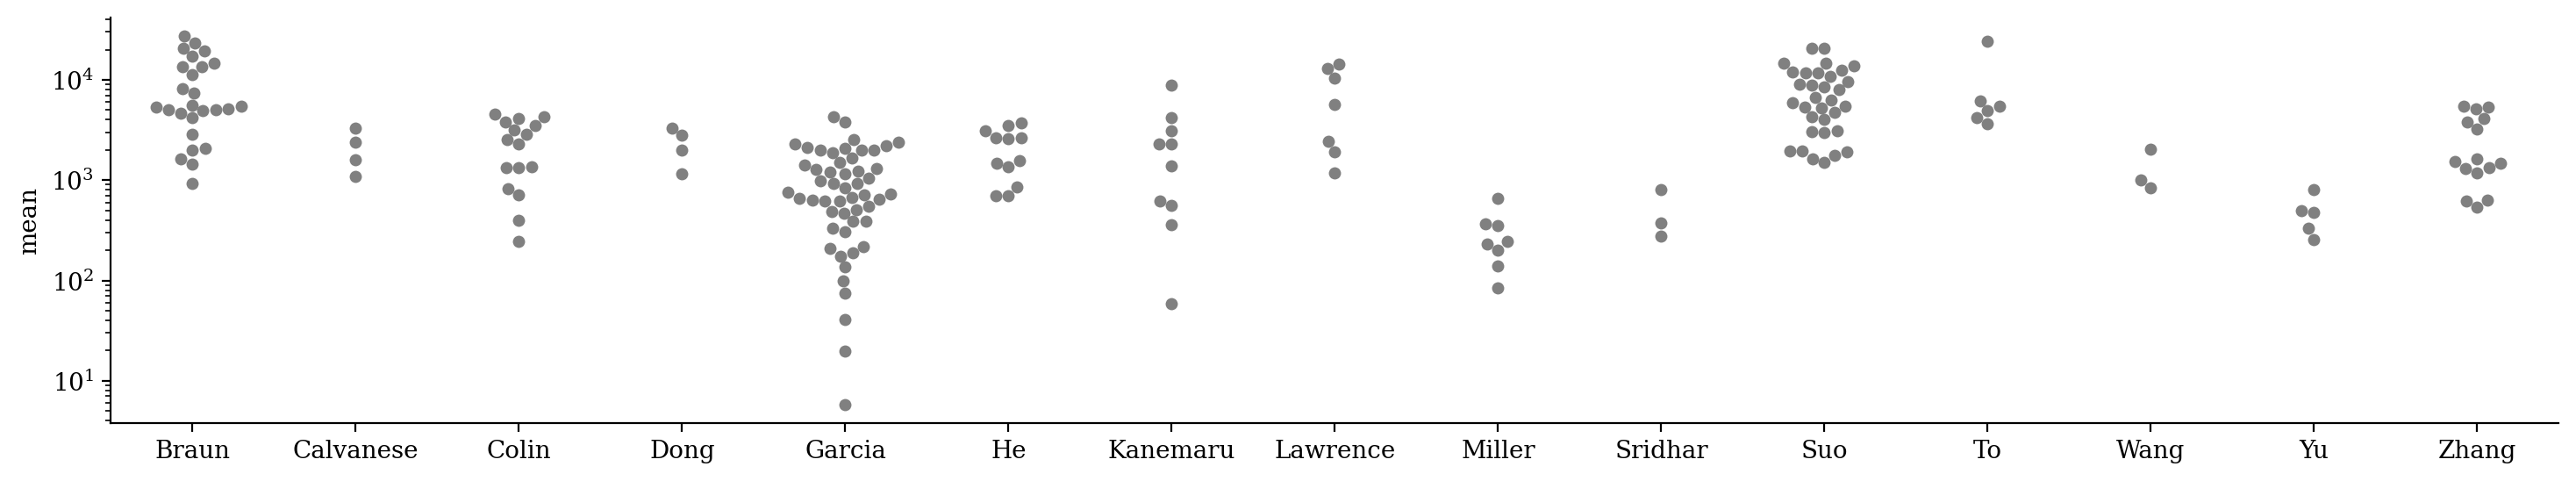

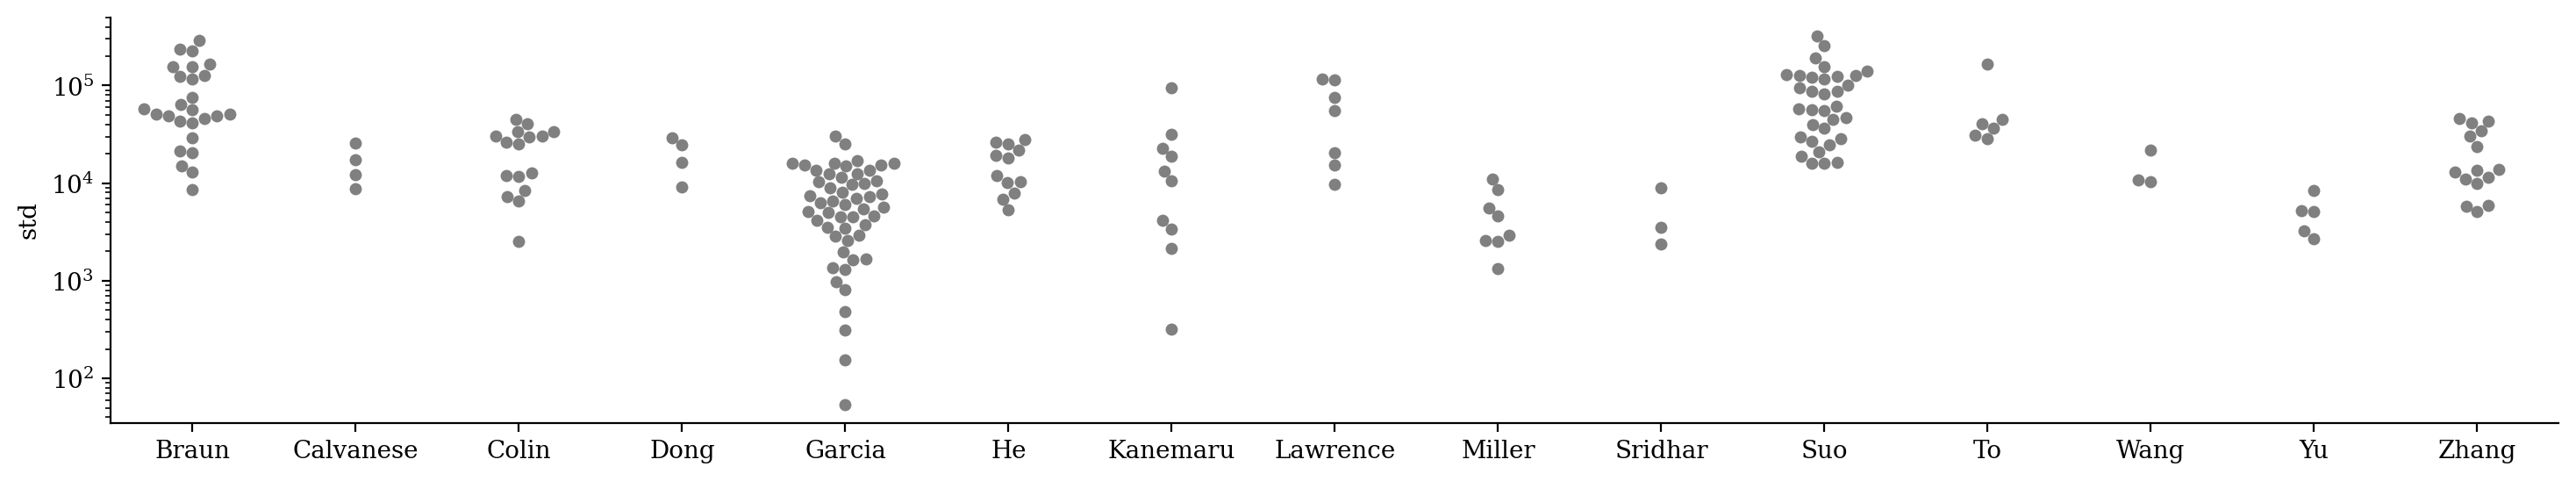

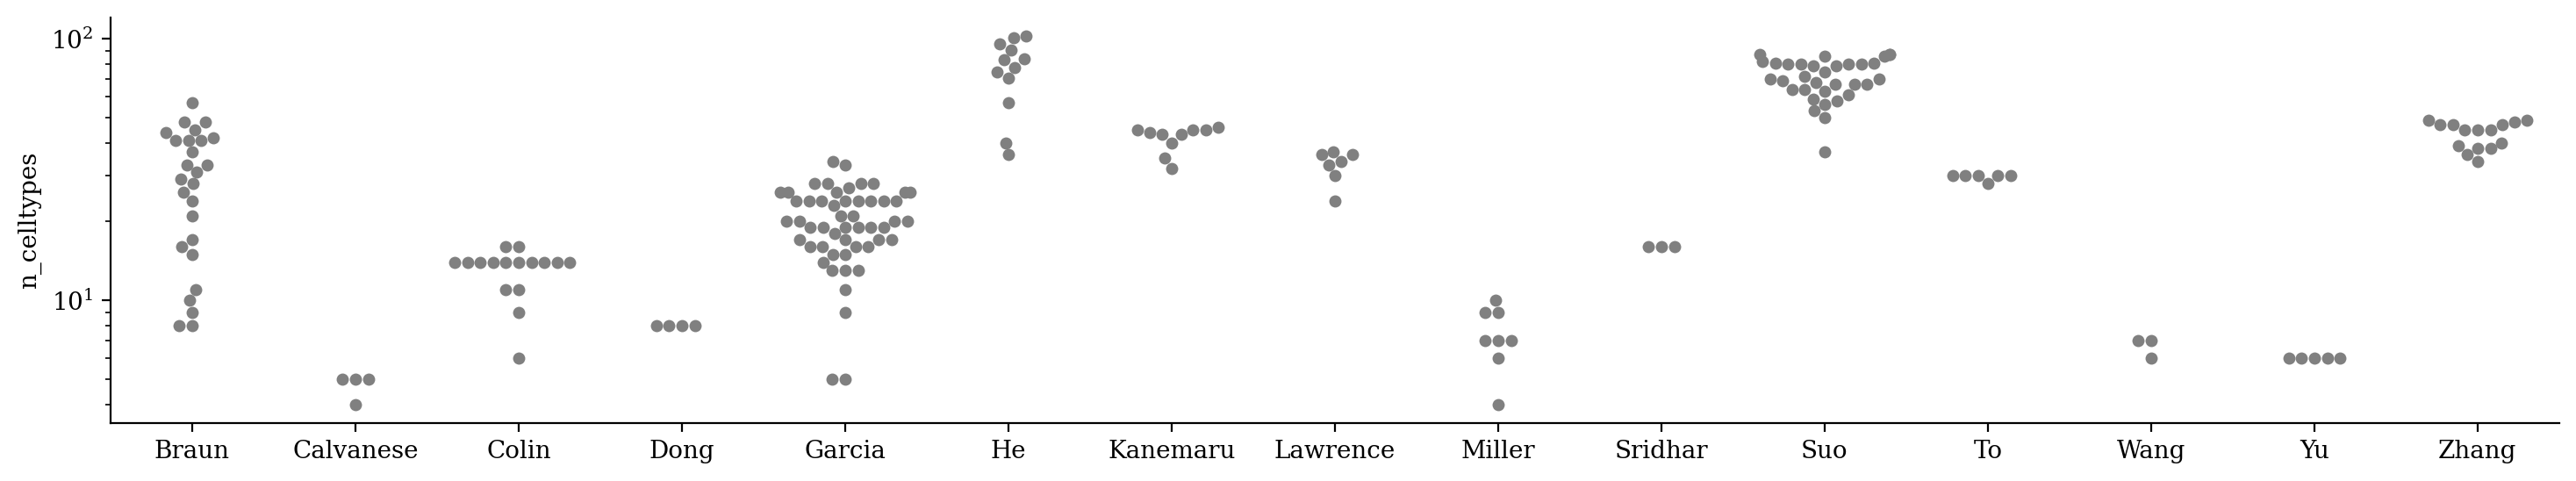

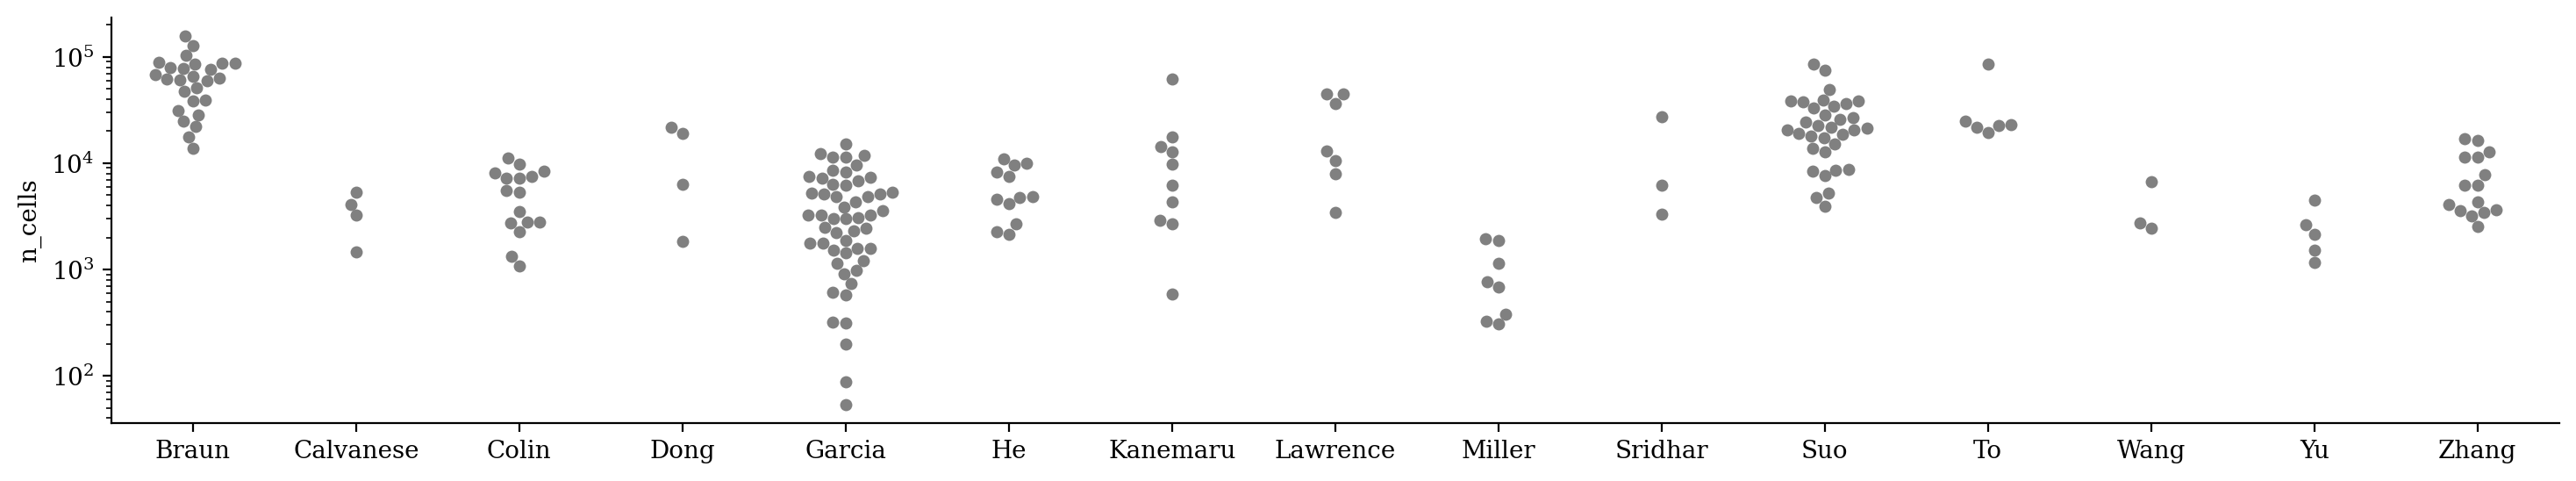

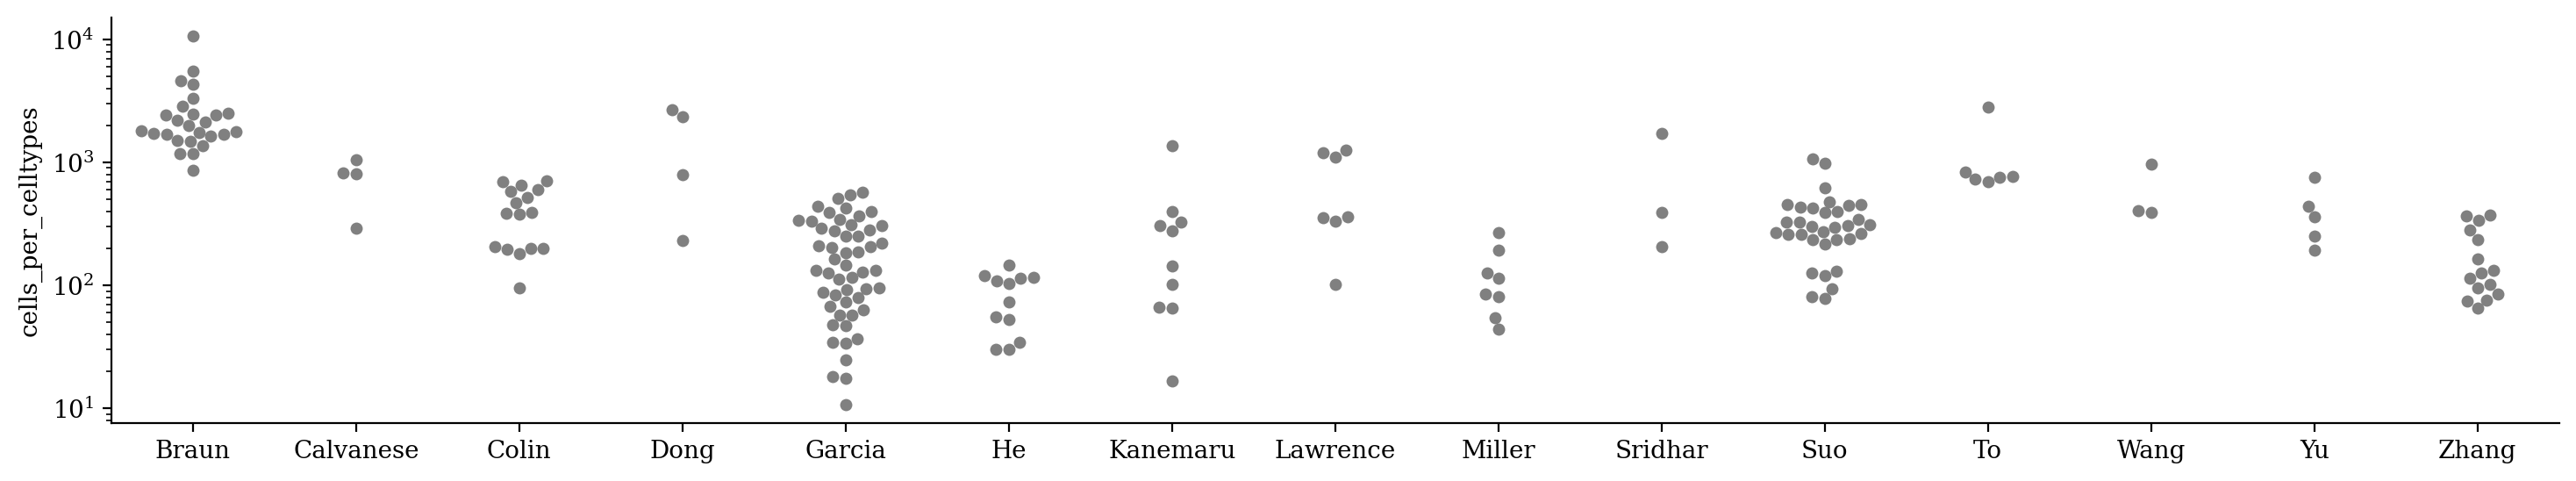

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for y in ["mean", "std", "n_celltypes", "n_cells", "cells_per_celltypes"]:
        plt.figure(figsize=(18, 3))
        sns.swarmplot(batch_stats, x="dataset", y=y, color="gray")
        sns.despine()
        plt.xlabel("")
        plt.yscale("log")
        plt.show()

In [9]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(batch_stats)

,dataset,batch_key,sex,organ,age,library_platform,biological_unit,sample_status,n_library_platform,n_biological_unit,n_sample_status,n_sex,n_organ,n_age,n_celltypes,n_cells,n_genes,cells_per_celltypes,sum,mean,std,median
0,Braun,BRC2006_Braun_et_al_Cell_Fresh_3GEX,[M],[Brain],[8.0],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,28,47237,55612,1687.035714,2.327087e+08,4184.505197,41216.921684,9.0
1,Braun,XHU:292_Braun_et_al_Cell_Fresh_3GEX,[F],[Brain],[9.5],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,17,28647,55612,1685.117647,1.114067e+08,2003.286053,21162.856727,4.0
2,Braun,BRC2021_Braun_et_al_Cell_Fresh_3GEX,[M],[Brain],[8.0],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,8,13738,55612,1717.250000,5.124685e+07,921.507031,8663.570653,4.0
3,Braun,XHU:297_Braun_et_al_Cell_Fresh_3GEX,[F],[Brain],[10.0],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,16,88859,55612,5553.687500,4.575920e+08,8228.295458,76347.439606,17.0
4,Braun,BRC2057_Braun_et_al_Cell_Fresh_3GEX,[F],[Brain],[8.1],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,21,31473,55612,1498.714286,1.148144e+08,2064.562433,20355.687114,8.0
5,Braun,BRC2073_Braun_et_al_Cell_Fresh_3GEX,[M],[Brain],[6.6],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,29,24830,55612,856.206897,8.068477e+07,1450.851849,13104.189928,5.0
6,Braun,XHU:305_Braun_et_al_Cell_Fresh_3GEX,[F],[Brain],[7.5],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,9,38870,55612,4318.888889,1.608844e+08,2892.980166,29176.842637,6.0
7,Braun,XHU:307_Braun_et_al_Cell_Fresh_3GEX,[F],[Brain],[9.2],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,41,86890,55612,2119.268293,2.791928e+08,5020.369345,48734.469376,18.0
8,Braun,BRC2106A_Braun_et_al_Cell_Fresh_3GEX,[F],[Brain],[6.6],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,31,62023,55612,2000.741935,2.792815e+08,5021.964486,46220.888215,16.0
9,Braun,BRC2110_Braun_et_al_Cell_Fresh_3GEX,[M],[Brain],[6.9],[3GEX],[Cell],[Fresh],1,1,1,1,1,1,41,60386,55612,1472.829268,2.736839e+08,4921.310059,48971.225168,17.0
